# Z by HP Unlocked Challenge 4

## The Task
The challenge is to build a machine learning model to classify images of "La Eterna". This can be done in a variety of ways. For this tutorial we will be focusing on building an image classification using artificial neural nets (ANN).

## What we're going to cover
* Using the data from (`Z by HP Unlocked Challenge 4`)
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (making our datasets run fast)
* Creating modelling callbacks
* Setting up mixed precision training
* Building a feature extraction model
* Fine-tuning the feature extraction model

In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras import layers

## download the data.

In [2]:
!wget https://www.hp.com/content/dam/sites/worldwide/apps/z-unlocked/v2/challenges/static/assignments/challenge-4.zip


--2023-01-22 15:13:02--  https://www.hp.com/content/dam/sites/worldwide/apps/z-unlocked/v2/challenges/static/assignments/challenge-4.zip
Resolving www.hp.com (www.hp.com)... 23.53.34.26, 23.53.34.18, 2600:1409:9800:23::1735:7a0f, ...
Connecting to www.hp.com (www.hp.com)|23.53.34.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘challenge-4.zip’

challenge-4.zip         [     <=>            ]  23.56M  24.4MB/s    in 1.0s    

2023-01-22 15:13:04 (24.4 MB/s) - ‘challenge-4.zip’ saved [24704435]



### Split the data to (train and validation )

First, let's unzip the data.

In [3]:
# Unzip the downloaded file
import zipfile

zip_ref = zipfile.ZipFile("challenge-4.zip")
zip_ref.extractall()
zip_ref.close()
     

Move the data to new folder

In [4]:
os.mkdir("data")

In [5]:
import shutil
  
# Source path
source = "/content/challenge-4/data_cleaned/Train/la_eterna"
source1 ="/content/challenge-4/data_cleaned/Train/other_flowers"
# Destination path
destination = "/content/data"
  
# Move the content of
# source to destination
dest = shutil.move(source, destination)
dest1 = shutil.move(source1, destination)

#### Now, Let's spilt our data to (traina nd validation) directories

In [6]:
# spilt data
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# spilt data to train/val/test
import splitfolders # or import splitfolders
input_folder = "/content/data"
output = "/content/data" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .2)) # ratio of split are in order of train/val. You can change to whatever

Copying files: 536 files [00:00, 6535.67 files/s]


## Preprocessing the data

In [8]:
train_dir = "/content/data/train"
val_dir = "/content/data/val/"

In [11]:
# Get the classnames programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/data/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))

In [13]:
# Let's visualize our images
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Cet a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

['la_eterna_21.jpg']
Image shape: (224, 224, 3)


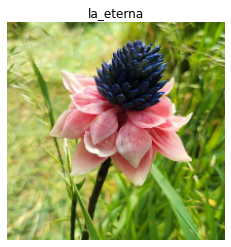

In [14]:
# View a random image from the training dataset
img = view_random_image(target_dir="/content/data/train/",
                        target_class=random.choice(class_names))

Let's use the `image_dataset_from_directory()` function to turn our images and labels into a tf.data.Dataset, a TensorFlow datatype which allows for us to pass it directory to our model.

In [169]:
# Setup data inputs
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                  image_size=IMG_SIZE)

val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                              label_mode="categorical",
                                                              image_size=IMG_SIZE) 

Found 428 files belonging to 2 classes.
Found 108 files belonging to 2 classes.


## Train Feature Extraction model

Here are the step's we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our wn output layer)
* Compile our model
* Feature extract for 5 full passes

Let's start by creating the `ModelCheckpoint` callback.

Since we want our model to perform well on unseen data we'll set it to monitor the validation accuracy metric and save the model weights which score the best on that.

In [170]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only=True,
                                                        moniter="val_accuracy",
                                                        save_best_only=True)

In [171]:
# Import some tensorflow liberaries to make or model looks nice
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

Checkpoint ready. Now let's create a small data augmentation model with the Sequential API. Because we're working with a reduced sized training set, this will help prevent our model from overfitting on the training data.

In [172]:
# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [173]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

In [174]:
# Get a summary of our model
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                                 
Total params: 4,052,133
Trainable params: 2,562
Non-trainab

*  Time to compile and fit.

In [175]:
# Compile
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history= model.fit(train_data,
                   epochs=5, # fit for 5 epochs to keep experiments quick
                   validation_data=val_data,
                   validation_steps= (len(val_data)), # evaluate on smaller portion of validation data
                   callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
14/14 [==============================] - 10s 331ms/step - loss: 0.5774 - accuracy: 0.6963 - val_loss: 0.4817 - val_accuracy: 0.7222
Epoch 2/5
14/14 [==============================] - 4s 254ms/step - loss: 0.4035 - accuracy: 0.8458 - val_loss: 0.3321 - val_accuracy: 0.9537
Epoch 3/5
14/14 [==============================] - 4s 261ms/step - loss: 0.2990 - accuracy: 0.9579 - val_loss: 0.2561 - val_accuracy: 0.9537
Epoch 4/5
14/14 [==============================] - 4s 249ms/step - loss: 0.2305 - accuracy: 0.9696 - val_loss: 0.2127 - val_accuracy: 0.9537
Epoch 5/5
14/14 [==============================] - 3s 217ms/step - loss: 0.1978 - accuracy: 0.9790 - val_loss: 0.1849 - val_accuracy: 0.9630


In [176]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(val_data)
results_feature_extraction_model

4/4 [==============================] - 0s 53ms/step - loss: 0.1849 - accuracy: 0.9630


[0.18490463495254517, 0.9629629850387573]

In [177]:
# Create a loss curves function
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

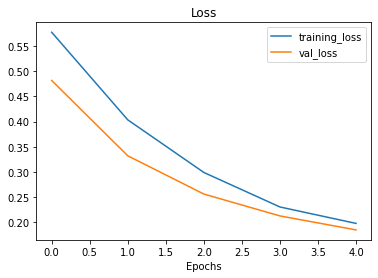

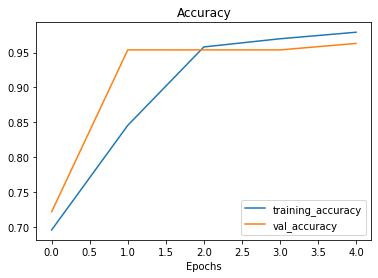

In [178]:
plot_loss_curves(history)

## Fine-tuning our model

In [179]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [180]:
# Recompile model with lower learning rate
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [181]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [182]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_fine_tune = model.fit(train_data,
                              epochs=fine_tune_epochs,
                              validation_data=val_data,
                              validation_steps=int(len(val_data)), # validate on 15% of the validation data
                              initial_epoch=history.epoch[-1]) # start from previous last epoch

Epoch 5/10
14/14 [==============================] - 11s 348ms/step - loss: 0.1513 - accuracy: 0.9743 - val_loss: 0.1078 - val_accuracy: 0.9815
Epoch 6/10
14/14 [==============================] - 3s 199ms/step - loss: 0.0988 - accuracy: 0.9860 - val_loss: 0.0868 - val_accuracy: 0.9630
Epoch 7/10
14/14 [==============================] - 3s 210ms/step - loss: 0.0724 - accuracy: 0.9930 - val_loss: 0.0536 - val_accuracy: 0.9907
Epoch 8/10
14/14 [==============================] - 3s 203ms/step - loss: 0.0528 - accuracy: 0.9930 - val_loss: 0.0526 - val_accuracy: 0.9815
Epoch 9/10
14/14 [==============================] - 3s 211ms/step - loss: 0.0517 - accuracy: 0.9883 - val_loss: 0.0320 - val_accuracy: 0.9907
Epoch 10/10
14/14 [==============================] - 3s 215ms/step - loss: 0.0300 - accuracy: 0.9953 - val_loss: 0.0337 - val_accuracy: 0.9907


In [183]:
# Evaluate fine-tuned model on the whole test dataset
results_fine_tune = model.evaluate(val_data)
results_fine_tune

4/4 [==============================] - 0s 54ms/step - loss: 0.0337 - accuracy: 0.9907


[0.033662863075733185, 0.9907407164573669]

In [184]:

# Create function to compare history
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

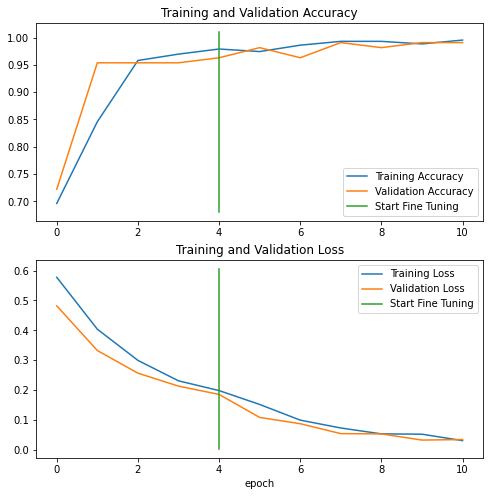

In [185]:
compare_historys(original_history=history,
                 new_history=history_fine_tune,
                 initial_epochs=5)

In [186]:
loss, accuracy = model.evaluate(val_data)
loss, accuracy

4/4 [==============================] - 0s 54ms/step - loss: 0.0337 - accuracy: 0.9907


(0.03366286680102348, 0.9907407164573669)

## Create Sample Submission

### Preprocessing the data

In [187]:
submission_dr = "/content/challenge-4/data_cleaned/scraped_images/"

In [188]:
submission = tf.keras.preprocessing.image_dataset_from_directory(submission_dr,
                                                                label_mode=None,
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 100 files belonging to 1 classes.


### Make prediction

In [189]:
pred_probs = model.predict(submission)

4/4 [==============================] - 1s 69ms/step


In [190]:
pred_probs

array([[9.96406376e-01, 3.59362992e-03],
       [2.69716338e-08, 1.00000000e+00],
       [7.93914485e-04, 9.99206126e-01],
       [2.43017197e-08, 1.00000000e+00],
       [4.41925749e-06, 9.99995589e-01],
       [1.60010177e-06, 9.99998450e-01],
       [4.51130336e-06, 9.99995470e-01],
       [7.72966541e-06, 9.99992251e-01],
       [5.95099737e-05, 9.99940515e-01],
       [1.19391359e-07, 9.99999881e-01],
       [2.99147246e-06, 9.99997020e-01],
       [1.15912817e-05, 9.99988437e-01],
       [1.19497112e-04, 9.99880433e-01],
       [1.23133959e-05, 9.99987721e-01],
       [2.84122361e-05, 9.99971628e-01],
       [3.17268018e-06, 9.99996781e-01],
       [1.35079690e-05, 9.99986529e-01],
       [9.82579708e-01, 1.74202770e-02],
       [8.20735238e-07, 9.99999166e-01],
       [9.99991775e-01, 8.17811360e-06],
       [1.96760942e-04, 9.99803245e-01],
       [3.09372590e-05, 9.99969006e-01],
       [6.77862454e-06, 9.99993205e-01],
       [5.02204616e-03, 9.94977891e-01],
       [5.150919

In [ ]:
preds = tf.squeeze(tf.round(pred_probs))
preds = tf.cast(preds , dtype = tf.int32)
preds

In [222]:
onlyfiles = [f.split('.')[0] for f in os.listdir(os.path.join('/content/challenge-4/data_cleaned/scraped_images/image_files'))]
onlyfiles.sort()
submission_df = pd.DataFrame(onlyfiles, columns =['images'])
submission_df[['la_eterna','other_flower']] = preds.numpy()
submission_df.head()


,images,la_eterna,other_flower
0,img_00,1,0
1,img_01,0,1
2,img_02,0,1
3,img_03,0,1
4,img_04,0,1


### Create CSV file 

In [223]:
submission_df.to_csv('submission_file.csv', index = False)